In [72]:
import numpy as np
import pandas as pd
import re

In [73]:
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'

    return(HTML(s+css))

In [74]:
pd.set_option('display.max_colwidth', 400)

In [75]:
jeopardy = pd.read_csv('jeopardy.csv')

In [76]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams


In [77]:
jeopardy.columns = jeopardy.columns.str.replace(' ','')

In [78]:
def normalize(string):
    string = string.lower().replace('\'', '')
    string = re.sub('<.*>', '', string)
    string = re.sub('\W+', ' ', string)
    return string.strip()

In [79]:
jeopardy['clean_question'] = jeopardy['Question'].apply(normalize)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize)

In [80]:
jeopardy.head()

,ShowNumber,AirDate,Round,Category,Value,Question,Answer,clean_question,clean_answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory",Copernicus,for the last 8 years of his life galileo was under house arrest for espousing this mans theory,copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,"No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves",Jim Thorpe,no 2 1912 olympian football star at carlisle indian school 6 mlb seasons with the reds giants braves,jim thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,"The city of Yuma in this state has a record average of 4,055 hours of sunshine each year",Arizona,the city of yuma in this state has a record average of 4 055 hours of sunshine each year,arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", this company served its billionth burger",McDonald's,in 1963 live on the art linkletter show this company served its billionth burger,mcdonalds
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Constitution of Mass., second President of the United States",John Adams,signer of the dec of indep framer of the constitution of mass second president of the united states,john adams


In [81]:
def dollar_normalize(amount):
    amount = amount.replace('$','')
    try:
        amount = int(amount)
    except:
        amount = 0
    return amount

In [82]:
jeopardy['clean_value'] = jeopardy['Value'].apply(dollar_normalize)

In [83]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 10 columns):
ShowNumber        19999 non-null int64
AirDate           19999 non-null object
Round             19999 non-null object
Category          19999 non-null object
Value             19999 non-null object
Question          19999 non-null object
Answer            19999 non-null object
clean_question    19999 non-null object
clean_answer      19999 non-null object
clean_value       19999 non-null int64
dtypes: int64(2), object(8)
memory usage: 1.5+ MB


In [84]:
jeopardy['AirDate'] = pd.to_datetime(jeopardy['AirDate'])

In [85]:
def answer_from_question(Series):
    split_answer = Series['clean_answer'].split()
    split_question = Series['clean_question'].split()
    
    match_count = 0
    try:
        split_answer.remove('the')
    except ValueError:
        pass
    if len(split_answer) == 0:
        return 0
    else:
        for word in split_answer:
            if word in split_question:
                match_count += 1
        result = match_count/len(split_answer)
        return result

In [86]:
jeopardy['answer_in_question'] = jeopardy.apply(answer_from_question, axis=1)

In [87]:
jeopardy['answer_in_question'].mean()

0.05745340338945034

According to the above, we can expect the answer to a given jeopardy question to be mentioned in the question approximately 6% of the time.

Now looking at how frequently jeopardy questions are repeated:

In [88]:
question_overlap = []
terms_used = set()
question_relation = dict()
word_to_match = []
    
jeopardy_sorted = jeopardy.sort_values('AirDate').reset_index(drop=True)

for index, row in jeopardy_sorted.iterrows():
    split_question = row['clean_question'].split()
    split_question = [greater for greater in split_question if len(greater) >= 6]
    match_count = 0

    for word in split_question:
        if word in terms_used:
            match_count += 1
        terms_used.add(word)
        word_to_match.append((index, word))
    
        
#     question_overlap[str(index)] = word_to_match
    if len(split_question) > 0:
        question_overlap.append(match_count/len(split_question))
        #Appending the ratio of repeated words to total words (each of length >=6)
    else:
        question_overlap.append(0)
jeopardy_sorted['question_overlap'] = question_overlap

In [89]:
word_to_match

[(0, 'adventurous'),
 (0, 'president'),
 (0, 'automobile'),
 (0, 'airplane'),
 (1, 'notorious'),
 (1, 'leader'),
 (1, 'missing'),
 (2, 'washington'),
 (2, 'proclaimed'),
 (2, 'national'),
 (2, 'holiday'),
 (3, 'colorado'),
 (3, 'national'),
 (4, 'depending'),
 (4, 'sawyer'),
 (5, 'hierarchy'),
 (5, 'actors'),
 (6, 'season'),
 (6, 'series'),
 (6, 'mourned'),
 (6, 'esterhaus'),
 (8, 'seaside'),
 (8, 'resort'),
 (8, 'monopoly'),
 (8, 'gambling'),
 (9, 'musketeers'),
 (9, 'camille'),
 (10, 'purchase'),
 (11, 'ponderosa'),
 (11, 'prairie'),
 (12, 'impressions'),
 (12, 'hollywood'),
 (13, 'thomas'),
 (14, 'ginger'),
 (14, 'rogers'),
 (14, 'partner'),
 (15, 'goodtime'),
 (16, 'thrilling'),
 (16, 'destination'),
 (16, 'walkers'),
 (16, 'honeymooners'),
 (17, 'irvings'),
 (17, 'chased'),
 (17, 'headless'),
 (17, 'horseman'),
 (19, 'jackie'),
 (19, 'gleason'),
 (19, 'rejected'),
 (19, 'titles'),
 (19, 'lovers'),
 (19, 'couple'),
 (20, 'totaling'),
 (20, 'trillion'),
 (20, 'treasury'),
 (20, 'est

In [90]:
print(jeopardy_sorted['question_overlap'].mean())
print(index)

0.7117085943652238
19998


In [91]:
jeopardy_sorted.head(10)

,ShowNumber,AirDate,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question,question_overlap
0,10,1984-09-21,Final Jeopardy!,U.S. PRESIDENTS,None,"Adventurous 26th president, he was 1st to ride in an automobile & an airplane",Theodore Roosevelt,adventurous 26th president he was 1st to ride in an automobile an airplane,theodore roosevelt,0,0.000000,0.0
1,10,1984-09-21,Double Jeopardy!,LABOR UNIONS,$200,Notorious labor leader missing since '75,Jimmy Hoffa,notorious labor leader missing since 75,jimmy hoffa,200,0.000000,0.0
2,10,1984-09-21,Double Jeopardy!,1789,$200,"Washington proclaimed Nov. 26, 1789 this first national holiday",Thanksgiving,washington proclaimed nov 26 1789 this first national holiday,thanksgiving,200,0.000000,0.0
3,10,1984-09-21,Double Jeopardy!,TOURIST TRAPS,$200,Both Ferde Grofe' & the Colorado River dug this national park,the Grand Canyon,both ferde grofe the colorado river dug this national park,the grand canyon,200,0.000000,0.5
4,10,1984-09-21,Double Jeopardy!,LITERATURE,$200,"Depending on the book, he could be a ""Jones"", a ""Sawyer"", or an ""Uncle""",Tom,depending on the book he could be a jones a sawyer or an uncle,tom,200,0.000000,0.0
5,10,1984-09-21,Double Jeopardy!,HOMONYMS,$200,Hindu hierarchy or a play's actors,a caste (cast),hindu hierarchy or a plays actors,a caste cast,200,0.333333,0.0
6,10,1984-09-21,Double Jeopardy!,TV TRIVIA,$200,"Last season, this series mourned the loss of Sgt. Esterhaus",Hill Street Blues,last season this series mourned the loss of sgt esterhaus,hill street blues,200,0.000000,0.0
7,10,1984-09-21,Double Jeopardy!,1789,$400,Why April 28th was a bad day for Capt. Bligh,the day of the mutiny on the Bounty,why april 28th was a bad day for capt bligh,the day of the mutiny on the bounty,400,0.142857,0.0
8,10,1984-09-21,Double Jeopardy!,TOURIST TRAPS,$400,Seaside resort that has a monopoly on East Coast gambling,"Atlantic City, New Jersey",seaside resort that has a monopoly on east coast gambling,atlantic city new jersey,400,0.000000,0.0
9,10,1984-09-21,Double Jeopardy!,LITERATURE,$400,"He wrote ""The 3 Musketeers""; his son wrote ""Camille""",(Alexandre) Dumas,he wrote the 3 musketeers his son wrote camille,alexandre dumas,400,0.000000,0.0


In [92]:
jeopardy_sorted['clean_value'].describe()

count    19999.000000
mean       661.393920
std        506.136278
min          0.000000
25%        300.000000
50%        500.000000
75%        800.000000
max       2000.000000
Name: clean_value, dtype: float64

In [93]:
terms_used

{'transsexual',
 'lomonosov',
 'crying',
 'bulletin',
 'pfeiffer',
 'kirshner',
 'mastiff',
 'fights',
 'heraldry',
 'lovesick',
 'diabetics',
 'kasespatzle',
 'deflect',
 'originally',
 'feather',
 'determines',
 'painful',
 'grammatically',
 'suribachi',
 'spearlike',
 'ivanovna',
 'frocks',
 'earthsea',
 'collision',
 'responsible',
 'nominations',
 'elephterian',
 'fletchers',
 'rangers',
 'denise',
 'crowds',
 'affinity',
 'mercury',
 'looming',
 'corporate',
 'glassworks',
 'mikhail',
 'segovia',
 'honeybee',
 'humans',
 'bowling',
 'dreadfully',
 'besleeve',
 'personality',
 'center',
 'allied',
 'pilots',
 'hillbillies',
 'preserve',
 'milligrams',
 'hamnet',
 'inflation',
 'informally',
 'notorious',
 'brentano',
 'nonlectures',
 'santini',
 'hurlevent',
 'antelope',
 'visitor',
 'televising',
 'farrell',
 'transformed',
 'botticellis',
 'hungarians',
 'menelaus',
 'twister',
 'sculptured',
 'interest',
 'woolsey',
 'construct',
 'sclera',
 'legitimate',
 'intoxicated',
 'abra

In [94]:
word_to_match
word_dict = {}

for idx, word in word_to_match:
    val = word_dict.get(word, False)
    if val == False:
        word_dict[word] = [idx]
    else:
        word_dict[word].append(idx)
len(word_dict)

20774

In [95]:
# word_dict = {key:value for key,value in word_dict.items() if len(value) > 1} #Drops words >= 6 chars 

# word_dict

As a side investigation.

Which questions overlapped with each other.  By looking at 'terms_used' and grabbing all the indexes for each word.

In [96]:
import re

Now I have a cleaned-up dictionary, relations, wherein the words in terms_used which got there only because they were at least 6 characters long, but aren't repeated, were removed.
'relations' contains each word in the question set at least 6 characters long and with at least a single repetition as keys, and the corresponding indexes in jeopardy_sorted where each word occurs.

Now we compare the questions and answers to see if any answers were repeated:

Making a sparse matrix with indexes the rows in 'jeopardy_sorted' and the columns the repeated words.

Above I computed the number of unique repeated words, whose corresponding sentences have the same answer.  That is 1504.
Then cleaned 'clean_answer' in the same way as I cleaned repeated words and answers previously but this time directly in the jeopardy_sorted dataframe.

#### Below:
I find the total number of repeated answers, 5766.

Now to construct the sparse matrix of index answers and columns repeared word bool

In [97]:
repeate_words_by_index = {unique_word: np.array([np.nan] * len(jeopardy_sorted)) for unique_word in word_dict.keys()}

for word, index in word_dict.items():
    repeate_words_by_index[word][list(index)] = 1
word_counts = pd.SparseDataFrame(repeate_words_by_index, index=jeopardy_sorted.index)

In [98]:
word_counts

,adventurous,president,automobile,airplane,notorious,leader,missing,washington,proclaimed,national,...,dramatically,frosty,albemarle,topographical,capers,millimeter,rhinoceros,haysbert,woodside,respectively
0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
print(word_counts.info())
print(jeopardy_sorted.info())

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Columns: 20774 entries, adventurous to respectively
dtypes: Sparse[float64, nan](20774)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 12 columns):
ShowNumber            19999 non-null int64
AirDate               19999 non-null datetime64[ns]
Round                 19999 non-null object
Category              19999 non-null object
Value                 19999 non-null object
Question              19999 non-null object
Answer                19999 non-null object
clean_question        19999 non-null object
clean_answer          19999 non-null object
clean_value           19999 non-null int64
answer_in_question    19999 non-null float64
question_overlap      19999 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 1.8+ MB
None


In [100]:
jeopardy_sorted.head()

,ShowNumber,AirDate,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question,question_overlap
0,10,1984-09-21,Final Jeopardy!,U.S. PRESIDENTS,None,"Adventurous 26th president, he was 1st to ride in an automobile & an airplane",Theodore Roosevelt,adventurous 26th president he was 1st to ride in an automobile an airplane,theodore roosevelt,0,0.0,0.0
1,10,1984-09-21,Double Jeopardy!,LABOR UNIONS,$200,Notorious labor leader missing since '75,Jimmy Hoffa,notorious labor leader missing since 75,jimmy hoffa,200,0.0,0.0
2,10,1984-09-21,Double Jeopardy!,1789,$200,"Washington proclaimed Nov. 26, 1789 this first national holiday",Thanksgiving,washington proclaimed nov 26 1789 this first national holiday,thanksgiving,200,0.0,0.0
3,10,1984-09-21,Double Jeopardy!,TOURIST TRAPS,$200,Both Ferde Grofe' & the Colorado River dug this national park,the Grand Canyon,both ferde grofe the colorado river dug this national park,the grand canyon,200,0.0,0.5
4,10,1984-09-21,Double Jeopardy!,LITERATURE,$200,"Depending on the book, he could be a ""Jones"", a ""Sawyer"", or an ""Uncle""",Tom,depending on the book he could be a jones a sawyer or an uncle,tom,200,0.0,0.0


In [101]:
word_counts.head()

,adventurous,president,automobile,airplane,notorious,leader,missing,washington,proclaimed,national,...,dramatically,frosty,albemarle,topographical,capers,millimeter,rhinoceros,haysbert,woodside,respectively
0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
answer_repeate_words = pd.concat([jeopardy_sorted['clean_answer'], word_counts], axis=1, join='inner')

In [103]:
answer_repeate_words.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Columns: 20775 entries, clean_answer to respectively
dtypes: Sparse[float64, nan](20774), Sparse[object, nan](1)
memory usage: 1.4 MB


In [104]:
answer_repeate_words.loc

In [105]:
len(answer_repeate_words.clean_answer.unique())
# answer_repeate_words.sort_values('clean_answer')
filt = answer_repeate_words['clean_answer'].value_counts() > 1

filt = filt[filt.values == True].index
answers_repeate = answer_repeate_words.loc[answer_repeate_words['clean_answer'].isin(list(filt))]

In [106]:
print(len(answers_repeate))
print(len(answer_repeate_words))

8702
19999


Repeat only is the dataframe with one's along the column in which the word is present (zeros elsewhere), and answers along the index pertaining to the jeopardy question.  It only contains questions for which answers are repeates

Now I want to ask: Of the questions, how many questions have the same answer and at least one repeated word? 

In [107]:
answer_groups = answers_repeate.groupby('clean_answer')

In [108]:
def repeate(series):
    series = series.loc[series > 1]
    
    if len(list(series.index)) >= 1:
        return list(series.index)
    else:
        return np.nan

In [109]:
output_pairs = pd.DataFrame(answer_groups.count().apply(repeate, axis=1).dropna(), columns=['word_s'])

In [110]:
answers_repeated_terms = list(answer_groups.count().apply(repeate, axis=1).dropna().index)
len(answers_repeated_terms)

1205

In [111]:
len(answers_repeate[answers_repeate.clean_answer.isin(answers_repeated_terms)])

4548

So of the 8702 questions which have the same answer to at least one other, there are 1205 answers which share at least one word with another question and have the same answer.  Totalling 4548 questions with at least one answer-word match.  Thats approx 23% of questions in the dataset!

Of the 8702 questions with the same answer as another, thats over 52% of questions.

In [112]:
4548/8702

0.5226384739140427

In [113]:
output_pairs['word_count'] = output_pairs['word_s'].apply(lambda x: len(x))

In [114]:
output_pairs.sort_values('word_count', ascending=False)

,word_s,word_count
clean_answer,,
india,"[populous, country, nation, countrys, defeated, democracy, bollywood, jainism, madhya, pradesh]",10
australia,"[country, countrys, became, continent, lowest, aboriginal, continents, queensland, kangaroo, commonwealth]",10
new zealand,"[country, nation, countrys, island, australia, separates, tasman, auckland]",8
china,"[called, populous, country, countrys, became, around, during, borders]",8
chicago,"[largest, worlds, musical, american, architect, institute, peshtigo, midwest]",8
venus,"[because, goddess, planet, brightest, planets, greenhouse, effect, earths]",8
the federalist papers,"[hamilton, october, ratification, constitution, essays, appeared, madison]",7
thomas jefferson,"[president, presidents, daughter, independence, future, declaration, clotel]",7
ontario,"[states, united, border, province, canadian, niagara]",6


In [115]:
output_pairs.describe(percentiles=[0.5,0.6,0.7, 0.8, 0.9, 0.95])

,word_count
count,1205.000000
mean,1.634025
std,1.102551
min,1.000000
50%,1.000000
60%,1.000000
70%,2.000000
80%,2.000000
90%,3.000000
95%,4.000000


Moving on from word-answer pairs, let's look at the relationship between questions and their values.
Say you only want to look at high-value questions, where we define high-value to mean a value greater than $800.  We can use the same terms_used set as before and find the relative number of high to low value questions each term occurs in.

In [116]:
terms_used

{'transsexual',
 'lomonosov',
 'crying',
 'bulletin',
 'pfeiffer',
 'kirshner',
 'mastiff',
 'fights',
 'heraldry',
 'lovesick',
 'diabetics',
 'kasespatzle',
 'deflect',
 'originally',
 'feather',
 'determines',
 'painful',
 'grammatically',
 'suribachi',
 'spearlike',
 'ivanovna',
 'frocks',
 'earthsea',
 'collision',
 'responsible',
 'nominations',
 'elephterian',
 'fletchers',
 'rangers',
 'denise',
 'crowds',
 'affinity',
 'mercury',
 'looming',
 'corporate',
 'glassworks',
 'mikhail',
 'segovia',
 'honeybee',
 'humans',
 'bowling',
 'dreadfully',
 'besleeve',
 'personality',
 'center',
 'allied',
 'pilots',
 'hillbillies',
 'preserve',
 'milligrams',
 'hamnet',
 'inflation',
 'informally',
 'notorious',
 'brentano',
 'nonlectures',
 'santini',
 'hurlevent',
 'antelope',
 'visitor',
 'televising',
 'farrell',
 'transformed',
 'botticellis',
 'hungarians',
 'menelaus',
 'twister',
 'sculptured',
 'interest',
 'woolsey',
 'construct',
 'sclera',
 'legitimate',
 'intoxicated',
 'abra

In [117]:
def val_analysis(row):
    if row['clean_value'] > 800:
        value = 1
    elif row['clean_value'] <= 800:
        value = 0
    return value

In [118]:
jeopardy_sorted['high_value'] = jeopardy_sorted.apply(val_analysis, axis=1)

In [119]:
high_value_count = 4972
low_value_count = 15027

def val_assignment(word):
    low_count = 0
    high_count = 0
    
    for index, row in jeopardy_sorted.iloc[word_dict[word]].iterrows():
        ques = row['clean_question'].split()
        if word in ques:
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
    per_ques = len(word_dict[word])/19999
    
    low_expec = per_ques * low_value_count
    high_expec = per_ques * high_value_count
    
    result = [(low_count, high_count), (low_expec, high_expec)]
    return result

In [120]:
len(word_dict['president'])

258

In [121]:
comparison_terms = list(terms_used)

In [122]:
observed_expected = []
for term in comparison_terms:
    out = val_assignment(term)
    observed_expected.append(out)

In [123]:
jeopardy_sorted['high_value'].value_counts()

0    15027
1     4972
Name: high_value, dtype: int64

In [124]:
from scipy.stats import chisquare

In [125]:
chi_squared = []

for row in observed_expected:
    obs = row[0]
    exp = row[1]
    chi, p_val = chisquare(obs, exp)
    chi_squared.append([chi, p_val])

In [126]:
chi_squared

[[0.661742197378053, 0.4159455550913673],
 [3.022325020112631, 0.08212564786568953],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [1.6543554934451319, 0.19836716034809856],
 [3.022325020112631, 0.08212564786568953],
 [0.3308710986890265, 0.565146603267378],
 [0.6765980594008285, 0.4107606373026975],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [0.29598206541314886, 0.5864123386844442],
 [1.323484394756106, 0.2499676669229765],
 [0.3308710986890265, 0.565146603267378],
 [0.9926132960670793, 0.31910449982424866],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [0.3308710986890265, 0.565146603267378],
 [3.022325020112631, 0.08212564786568953],
 [0.661742197378053, 0.4

In [127]:
chi_test = pd.DataFrame(chi_squared, index = comparison_terms, columns = ['chi_stat', 'p_val'])
ob_exp = pd.DataFrame([[obs[0], obs[1], exp[0], exp[1]] for obs, exp in observed_expected], columns = 
                                                ['observed_low', 'observed_high', 'expected_low', 'expected_high'],
            index = comparison_terms)

In [128]:
result_df = pd.concat([chi_test, ob_exp], axis=1)

In [129]:
result_df.head()

,chi_stat,p_val,observed_low,observed_high,expected_low,expected_high
transsexual,0.661742,0.415946,2,0,1.502775,0.497225
lomonosov,3.022325,0.082126,0,1,0.751388,0.248612
crying,0.330871,0.565147,1,0,0.751388,0.248612
bulletin,0.330871,0.565147,1,0,0.751388,0.248612
pfeiffer,0.330871,0.565147,1,0,0.751388,0.248612


In [130]:
result_df[result_df['observed_low'] > result_df['expected_low']].sort_values('p_val')

,chi_stat,p_val,observed_low,observed_high,expected_low,expected_high
double,8.446679,0.003657,38,2,30.055503,9.944497
sitcom,7.668074,0.005621,41,3,33.061053,10.938947
theres,7.609609,0.005806,46,4,37.569378,12.430622
international,6.726337,0.009500,43,4,35.315216,11.684784
government,6.376281,0.011566,56,7,47.337417,15.662583
countries,6.154099,0.013111,36,3,29.304115,9.695885
continent,5.933540,0.014855,30,2,24.044402,7.955598
countrys,5.896215,0.015173,80,13,69.879044,23.120956
saturday,5.293938,0.021400,16,0,12.022201,3.977799
cheese,5.264432,0.021766,33,3,27.049952,8.950048


In [131]:
jeopardy_sorted['Round'].unique()

array(['Final Jeopardy!', 'Double Jeopardy!', 'Jeopardy!', 'Tiebreaker'],
      dtype=object)

In [132]:
jeopardy_sorted.describe(include='all')

,ShowNumber,AirDate,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_value,answer_in_question,question_overlap,high_value
count,19999.000000,19999,19999,19999,19999,19999,19999,19999,19999,19999.000000,19999.000000,19999.000000,19999.000000
unique,NaN,336,4,3581,76,19988,14963,19947,14233,NaN,NaN,NaN,NaN
top,NaN,2007-11-13 00:00:00,Jeopardy!,TELEVISION,$400,[audio clue],Japan,,japan,NaN,NaN,NaN,NaN
freq,NaN,62,9901,51,3892,5,22,39,22,NaN,NaN,NaN,NaN
first,NaN,1984-09-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2012-01-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4312.730537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,661.393920,0.057453,0.711709,0.248612
std,1374.121672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,506.136278,0.164297,0.302932,0.432219
min,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,3393.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.000000,0.000000,0.500000,0.000000


In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/isaac/anaconda3/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


/home/isaac/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


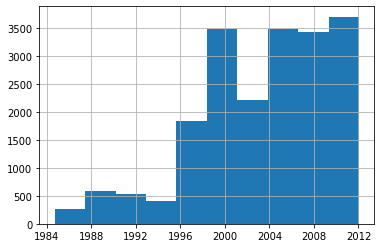

In [134]:
jeopardy_sorted['AirDate'].hist()

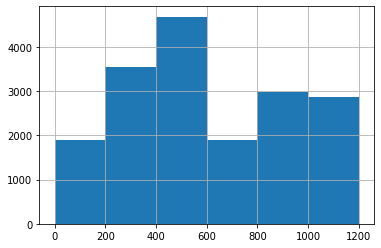

In [143]:
jeopardy_sorted[jeopardy_sorted['clean_value'] < 1500]['clean_value'].hist(bins = 6)